## Project: Deep Learning in for MR Elastography
### B. Model fitting

### 1. import functions and data

In [1]:
import scipy.io
import keras
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import pandas as pd
import random 
from keras.models import Sequential
from keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, UpSampling2D

from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import MinMaxScaler


%matplotlib inline 



/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Utility functions

In [27]:
def plot_autoencoder_outputs(autoencoder, n, dims):
    decoded_imgs = autoencoder.predict(x_test)

    # number of example digits to show
    n = 5
    plt.figure(figsize=(10, 4.5))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()

#### Import pre-processed data

In [4]:
df=pd.read_msgpack('/Users/syp/Desktop/git/mre/MREdata_072118.msg')

In [8]:
Ur=np.stack(df.Ur.values,axis=3).transpose(3,0,1,2)
Ui=np.stack(df.Ui.values,axis=3).transpose(3,0,1,2)

X=np.sqrt(Ui**2+Ur**2)

Y=np.stack(df.RS.values,axis=2).transpose(2,0,1)
#Y=Y.reshape(612,-1)
Y.ptp()

10000

#### Y is transformed 

In [9]:
# Data transformation (scale Y)
Y=Y/10000
print(X.shape)
print(Y.shape)
#print(Y.ptp)
Y.ptp()

(612, 64, 64, 3)
(612, 64, 64)


1.0

#### Split data into train, test and cross-valid samples

In [11]:
train_X,test_X,train_Y,test_Y=train_test_split(X,Y,test_size=0.3)
train_X,valid_X,train_Y,valid_Y=train_test_split(train_X,train_Y,test_size=0.3)

print(X.shape) #612,64,64,3
print(Y.shape) #612,4096
print(train_X.shape) #(299, 64, 64, 3)
print(valid_X.shape) #(129, 64, 64, 3)
print(test_Y.shape) #(184, 4096)



(612, 64, 64, 3)
(612, 64, 64)
(299, 64, 64, 3)
(129, 64, 64, 3)
(184, 64, 64)


### 2. Benchmark model: fully connected neural network

#### Flatten data to use neural network

In [20]:
train_x,train_y=train_X.reshape(len(train_X),-1),train_Y.reshape(len(train_Y),-1)
test_x,test_y=test_X.reshape(len(test_X),-1),test_Y.reshape(len(test_Y),-1)
valid_x,valid_y=valid_X.reshape(len(valid_X),-1),valid_Y.reshape(len(valid_Y),-1)
print(train_x.shape) #(299, 64, 64, 3)
print(valid_x.shape) #(129, 64, 64, 3)
print(test_y.shape) #(184, 4096)

(299, 12288)
(129, 12288)
(184, 4096)


In [61]:
model=Sequential()
model.add(Dense(32,activation='relu',input_shape=(train_x.shape[1],)))
#32= # of units

#adding a second layer
model.add(Dense(100,activation='relu'))

#adding a third layer
model.add(Dense(100,activation='relu'))

#Final Layer: needs to be the same size as your desired output
model.add(Dense(train_y.shape[1],activation='linear'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 32)                393248    
_________________________________________________________________
dense_18 (Dense)             (None, 100)               3300      
_________________________________________________________________
dense_19 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_20 (Dense)             (None, 4096)              413696    
Total params: 820,344
Trainable params: 820,344
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.compile(loss='mean_squared_error',
             optimizer='adam')

In [63]:
model.fit(train_x,train_y,epochs=20,batch_size=1,validation_data=(valid_x,valid_y))

Train on 299 samples, validate on 129 samples
Epoch 1/20
299/299 [==============================] - 3s 10ms/step - loss: 0.0273 - val_loss: 0.0338
Epoch 2/20
299/299 [==============================] - 3s 9ms/step - loss: 0.0221 - val_loss: 0.0151
Epoch 3/20
299/299 [==============================] - 3s 9ms/step - loss: 0.0175 - val_loss: 0.0132
Epoch 4/20
299/299 [==============================] - 3s 9ms/step - loss: 0.0126 - val_loss: 0.0102
Epoch 5/20
299/299 [==============================] - 3s 10ms/step - loss: 0.0088 - val_loss: 0.0079
Epoch 6/20
299/299 [==============================] - 3s 9ms/step - loss: 0.0071 - val_loss: 0.0062
Epoch 7/20
299/299 [==============================] - 3s 9ms/step - loss: 0.0059 - val_loss: 0.0057

In [30]:
ANNhistory=Out[26]

<Figure size 576x432 with 0 Axes>

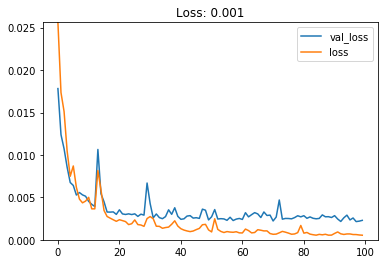

In [31]:
plot_loss(ANNhistory)

In [32]:
predict_y=model.predict(test_x).reshape(test_x.shape[0],64,64)

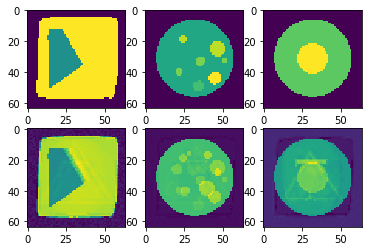

In [64]:
nimg=3
for i in range(nimg):
    ax=plt.subplot(2,nimg,i+1)
    plt.imshow(test_Y[i+10])
    ax=plt.subplot(2,nimg,i+1+nimg)
    plt.imshow(predict_y[i+10])

### 3. CNN imag reconstruction

In [37]:
#Autoencoder

model=Sequential()

#Convolution
model.add(Conv2D(64, kernel_size=(3, 3), strides=(2,2),padding="same",
                 activation='relu',
                 input_shape=(X.shape[1],X.shape[2],X.shape[3])))

model.add(Conv2D(50, kernel_size=(3, 3), strides=(2,2),padding="same",
                 activation='relu'))

model.add(Conv2D(32, kernel_size=(3, 3), strides=(2,2),padding="same",
                 activation='relu'))

model.add(Conv2D(32, kernel_size=(3, 3),padding="same",
                 activation='relu'))

model.add(Conv2D(32, kernel_size=(3, 3),padding="same",
                 activation='relu'))

#Deconvolution
# model.add(Conv2D(32, kernel_size=(3, 3),padding='same',
#                  activation='relu'))

model.add(UpSampling2D((2,2)))

model.add(Conv2D(32, kernel_size=(3, 3),padding='same',
                 activation='relu'))

model.add(UpSampling2D((2,2)))

model.add(Conv2D(32, kernel_size=(3, 3),padding='same',
                 activation='relu'))

model.add(UpSampling2D((2,2)))

model.add(Conv2D(1, kernel_size=(3, 3),padding='same',
                 activation='relu'))


# model.add(UpSampling2D((2,2)))
# model.add(Flatten())
# model.add(Dense(100, activation='relu'))
# model.add(Dense(Y.shape[1],activation='linear'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 50)        28850     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          14432     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 32)        9248      
__________

In [38]:
model.compile(loss='mean_squared_error',
              optimizer='adam')

train_Y=train_Y.reshape((train_Y.shape[0],64,64,1))
valid_Y=valid_Y.reshape((valid_Y.shape[0],64,64,1))


model.fit(train_X, train_Y,
          epochs=100,
          batch_size=1,
          validation_data=(valid_X, valid_Y))

Train on 299 samples, validate on 129 samples
Epoch 1/100
299/299 [==============================] - 4s 13ms/step - loss: 0.0300 - val_loss: 0.0207
Epoch 2/100
299/299 [==============================] - 4s 13ms/step - loss: 0.0215 - val_loss: 0.0179
Epoch 3/100
299/299 [==============================] - 4s 13ms/step - loss: 0.0165 - val_loss: 0.0141
Epoch 4/100
299/299 [==============================] - 4s 13ms/step - loss: 0.0140 - val_loss: 0.0115
Epoch 5/100
299/299 [==============================] - 4s 13ms/step - loss: 0.0122 - val_loss: 0.0103
Epoch 6/100
299/299 [==============================] - 4s 14ms/step - loss: 0.0104 - val_loss: 0.0089
Epoch 7/100
299/299 [==============================] - 4s 14ms/step - loss: 0.0091 - val_los

In [43]:
CNNhistory=Out[38]
predict_Y=model.predict(test_X)
print(predict_Y.shape)

(184, 64, 64, 1)


<Figure size 576x432 with 0 Axes>

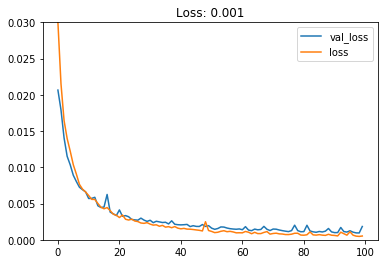

In [58]:
plot_loss(CNNhistory)

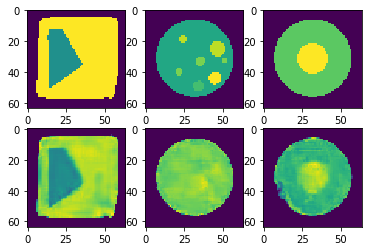

In [65]:
for i in range(nimg):
    ax=plt.subplot(2,nimg,i+1)
    plt.imshow(test_Y[i+10])
    ax=plt.subplot(2,nimg,i+1+nimg)
    plt.imshow(predict_Y[i+10,:,:,0])

<Figure size 576x432 with 0 Axes>

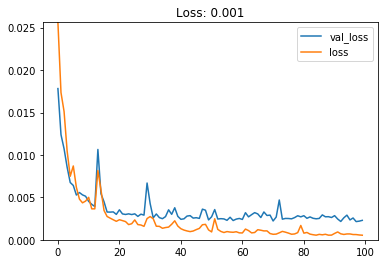

<Figure size 576x432 with 0 Axes>

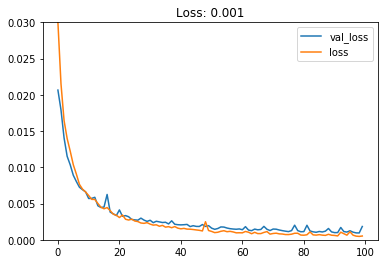

In [70]:
plot_loss(ANNhistory)
plt.hold
plot_loss(CNNhistory)

Future work

1. Increase number of neurons
2. Train longer (epochs)
3. batch size normalization
4. ResNet